In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
btvote = pd.read_pickle('../data/btvote.pkl')
btvote.head()

,party,vote_19001,vote_19002,vote_19003,vote_19004,vote_19005,vote_19006,vote_19007,vote_19008,vote_19009,...,vote_19235,vote_19236,vote_19237,vote_19238,vote_19239,vote_19240,vote_19241,vote_19242,vote_19243,vote_19244
0,CDU,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,SPD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN
2,Linke,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,CDU,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN
4,Linke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN


# NaN handling

### Delete full NaN groups
Delete all votes where all values of one party are NaN

In [3]:
unique_groups = btvote['party'].unique()
for group_value in unique_groups:
    group_df = btvote[btvote['party'] == group_value]
    nan_columns = group_df.columns[group_df.isna().all()]
    for column in nan_columns:
        print(column, end=' ')
    btvote = btvote.drop(nan_columns, axis=1)

vote_19042 vote_19047 vote_19048 vote_19051 vote_19054 vote_19060 vote_19072 vote_19080 vote_19097 vote_19106 vote_19132 vote_19151 vote_19152 vote_19162 vote_19194 vote_19207 vote_19219 vote_19061 vote_19077 vote_19095 vote_19100 vote_19103 vote_19200 vote_19221 vote_19224 vote_19228 vote_19079 vote_19085 vote_19123 vote_19143 vote_19144 vote_19211 vote_19182 

### Data Enrichment
Imputing of missing values (NaN)

- sklearn [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) with strategies *mean* and *mode/most_frequent*
- sklearn [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) with different *n_neighbors*
- sklearn **custom** GroupImputer with strategies *mean* and *mode*:

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a custom Imputer that imputes based on the party
class GroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy

    def fit(self, X, y):
        # store the y series to find the correct index in the transform function
        self.y = y
        # self.group_values becomes an attribute that is the map of group_specific values
        if self.strategy == 'mode':
            self.group_values = X.groupby(self.y).agg(lambda x: pd.Series.mode(x)[0])
        else:
            self.group_values = X.groupby(self.y).mean()
        return self

    def transform(self, X):
        for column in X.columns:
            if X[column].isna().any():
                # apply to all columns that contain any NaN values:
                # if the current cell in the DataFrame is a NaN value, return the group-specific value for that cell
                # othwerwise return the original value
                X[column] = X.apply(
                    lambda row: self.group_values.loc[self.y[row.name],column] if np.isnan(row[column])
                                   else row[column], axis=1)
        return X.to_numpy()

# Split data and encode target variable

In [3]:
# Split dataframe in 'data' and 'target'
btvote_data = btvote.drop('party', axis=1)
btvote_target = btvote['party']

# Encode the target variable
label_encoder = preprocessing.LabelEncoder()
btvote_target = label_encoder.fit_transform(btvote_target)

# Pipeline and GridSearch setup

In [8]:
from imblearn.pipeline import Pipeline
# imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
# balancing
from imblearn.over_sampling import RandomOverSampler
# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Pipeline
# 1. Imputing NaN values
# 2. Balancing
# 3. Classification
pipeline = Pipeline([('imputer', None), ('balancing', RandomOverSampler()), ('estimator', None)])

# set parameters
# TODO: extend parameter field by Classifiers. This is just an example of how the pipeline and GridSearch work on our data
parameters = [
    {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [KNeighborsClassifier()],
        'estimator__n_neighbors': range(2, 8),
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [DecisionTreeClassifier()],
        'estimator__max_depth': [3,6],
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [KMeans()],
        'estimator__n_clusters': [7],
        'estimator__n_init': [15],
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [NearestCentroid()],
        'estimator__metric': ['euclidean'],
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [GaussianNB()],
    }
]

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define the scoring function
f1 = make_scorer(f1_score, average='micro')

In [31]:
# run the complete grid search
# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# TODO: maybe use nested cross validation in the future
grid_search_estimator.fit(btvote_data, btvote_target)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__n_neighbors,param_imputer,param_estimator__max_depth,param_estimator__n_clusters,param_estimator__n_init,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005292,0.001454,0.004913,0.002993,KNeighborsClassifier(n_neighbors=3),2,SimpleImputer(),NaN,NaN,NaN,...,0.666667,0.720000,0.675676,0.675676,0.675676,0.689189,0.648649,0.692486,0.030273,13
1,0.011928,0.000250,0.003596,0.000368,KNeighborsClassifier(n_neighbors=3),2,SimpleImputer(strategy='most_frequent'),NaN,NaN,NaN,...,0.613333,0.720000,0.689189,0.783784,0.702703,0.648649,0.729730,0.702072,0.047140,11
2,0.275634,0.012306,0.106114,0.040047,KNeighborsClassifier(n_neighbors=3),2,KNNImputer(),NaN,NaN,NaN,...,0.693333,0.693333,0.689189,0.810811,0.702703,0.662162,0.770270,0.711514,0.044500,10
3,0.005957,0.002198,0.012346,0.014685,KNeighborsClassifier(n_neighbors=3),3,SimpleImputer(),NaN,NaN,NaN,...,0.680000,0.653333,0.662162,0.648649,0.635135,0.635135,0.648649,0.665640,0.030373,18
4,0.011693,0.000147,0.003704,0.000488,KNeighborsClassifier(n_neighbors=3),3,SimpleImputer(strategy='most_frequent'),NaN,NaN,NaN,...,0.680000,0.733333,0.702703,0.810811,0.743243,0.770270,0.729730,0.743676,0.042232,2
5,0.275129,0.022930,0.122588,0.035107,KNeighborsClassifier(n_neighbors=3),3,KNNImputer(),NaN,NaN,NaN,...,0.706667,0.706667,0.716216,0.810811,0.743243,0.783784,0.810811,0.746486,0.051176,1
6,0.005257,0.001597,0.014032,0.008238,KNeighborsClassifier(n_neighbors=3),4,SimpleImputer(),NaN,NaN,NaN,...,0.626667,0.666667,0.608108,0.608108,0.635135,0.635135,0.675676,0.650883,0.032443,20
7,0.011665,0.000257,0.003758,0.000352,KNeighborsClassifier(n_neighbors=3),4,SimpleImputer(strategy='most_frequent'),NaN,NaN,NaN,...,0.680000,0.733333,0.702703,0.770270,0.729730,0.729730,0.729730,0.722216,0.039602,8
8,0.276026,0.017333,0.096125,0.030971,KNeighborsClassifier(n_neighbors=3),4,KNNImputer(),NaN,NaN,NaN,...,0.706667,0.706667,0.716216,0.783784,0.729730,0.662162,0.810811,0.722270,0.045492,6
9,0.006096,0.001986,0.013120,0.011475,KNeighborsClassifier(n_neighbors=3),5,SimpleImputer(),NaN,NaN,NaN,...,0.613333,0.573333,0.581081,0.554054,0.648649,0.594595,0.621622,0.613333,0.038180,25


# Imputing analysis

In [13]:
parameters = [
    {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [KNeighborsClassifier(n_neighbors=7)],
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [DecisionTreeClassifier(max_depth=5)],
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [KMeans(n_clusters=7,n_init=15)],
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [NearestCentroid(metric='euclidean')],
    }, {
        'imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='most_frequent'), KNNImputer()],
        'estimator': [GaussianNB()],
    }
]

In [14]:
# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
# TODO: maybe use nested cross validation in the future
grid_search_estimator.fit(btvote_data, btvote_target)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_imputer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013199,0.000873,0.012898,1.445448e-03,KNeighborsClassifier(n_neighbors=7),SimpleImputer(),{'estimator': KNeighborsClassifier(n_neighbors...,0.613333,0.666667,0.693333,0.600000,0.600000,0.581081,0.567568,0.635135,0.527027,0.621622,0.610577,0.045444,10
1,0.038901,0.003014,0.012098,1.136130e-03,KNeighborsClassifier(n_neighbors=7),SimpleImputer(strategy='most_frequent'),{'estimator': KNeighborsClassifier(n_neighbors...,0.746667,0.693333,0.640000,0.666667,0.746667,0.675676,0.783784,0.689189,0.648649,0.716216,0.700685,0.044424,2
2,0.325850,0.012402,0.093151,3.035169e-03,KNeighborsClassifier(n_neighbors=7),KNNImputer(),{'estimator': KNeighborsClassifier(n_neighbors...,0.746667,0.760000,0.720000,0.706667,0.746667,0.702703,0.783784,0.743243,0.702703,0.743243,0.735568,0.025542,1
3,0.019406,0.000660,0.002900,5.388664e-04,DecisionTreeClassifier(max_depth=5),SimpleImputer(),{'estimator': DecisionTreeClassifier(max_depth...,0.733333,0.626667,0.680000,0.653333,0.653333,0.445946,0.486486,0.702703,0.689189,0.445946,0.611694,0.103954,9
4,0.039900,0.001874,0.002600,4.909164e-04,DecisionTreeClassifier(max_depth=5),SimpleImputer(strategy='most_frequent'),{'estimator': DecisionTreeClassifier(max_depth...,0.720000,0.653333,0.453333,0.653333,0.653333,0.459459,0.716216,0.702703,0.702703,0.675676,0.639009,0.094503,6
5,0.313638,0.012271,0.082632,2.557499e-03,DecisionTreeClassifier(max_depth=5),KNNImputer(),{'estimator': DecisionTreeClassifier(max_depth...,0.560000,0.706667,0.600000,0.613333,0.706667,0.689189,0.554054,0.527027,0.527027,0.716216,0.620018,0.073992,8
6,0.114711,0.003866,0.005800,3.997946e-04,"KMeans(n_clusters=7, n_init=15)",SimpleImputer(),"{'estimator': KMeans(n_clusters=7, n_init=15),...",0.266667,0.240000,0.000000,0.013333,0.493333,0.216216,0.108108,0.189189,0.270270,0.391892,0.218901,0.146269,15
7,0.145382,0.005180,0.006000,5.228928e-07,"KMeans(n_clusters=7, n_init=15)",SimpleImputer(strategy='most_frequent'),"{'estimator': KMeans(n_clusters=7, n_init=15),...",0.000000,0.360000,0.400000,0.000000,0.173333,0.202703,0.000000,0.256757,0.378378,0.500000,0.227117,0.174357,13
8,0.437762,0.008306,0.107251,2.693383e-03,"KMeans(n_clusters=7, n_init=15)",KNNImputer(),"{'estimator': KMeans(n_clusters=7, n_init=15),...",0.280000,0.400000,0.346667,0.200000,0.106667,0.148649,0.162162,0.121622,0.175676,0.283784,0.222523,0.094537,14
9,0.012400,0.001800,0.003400,6.641269e-04,NearestCentroid(),SimpleImputer(),"{'estimator': NearestCentroid(), 'imputer': Si...",0.746667,0.693333,0.680000,0.626667,0.706667,0.689189,0.648649,0.648649,0.635135,0.716216,0.679117,0.036803,3


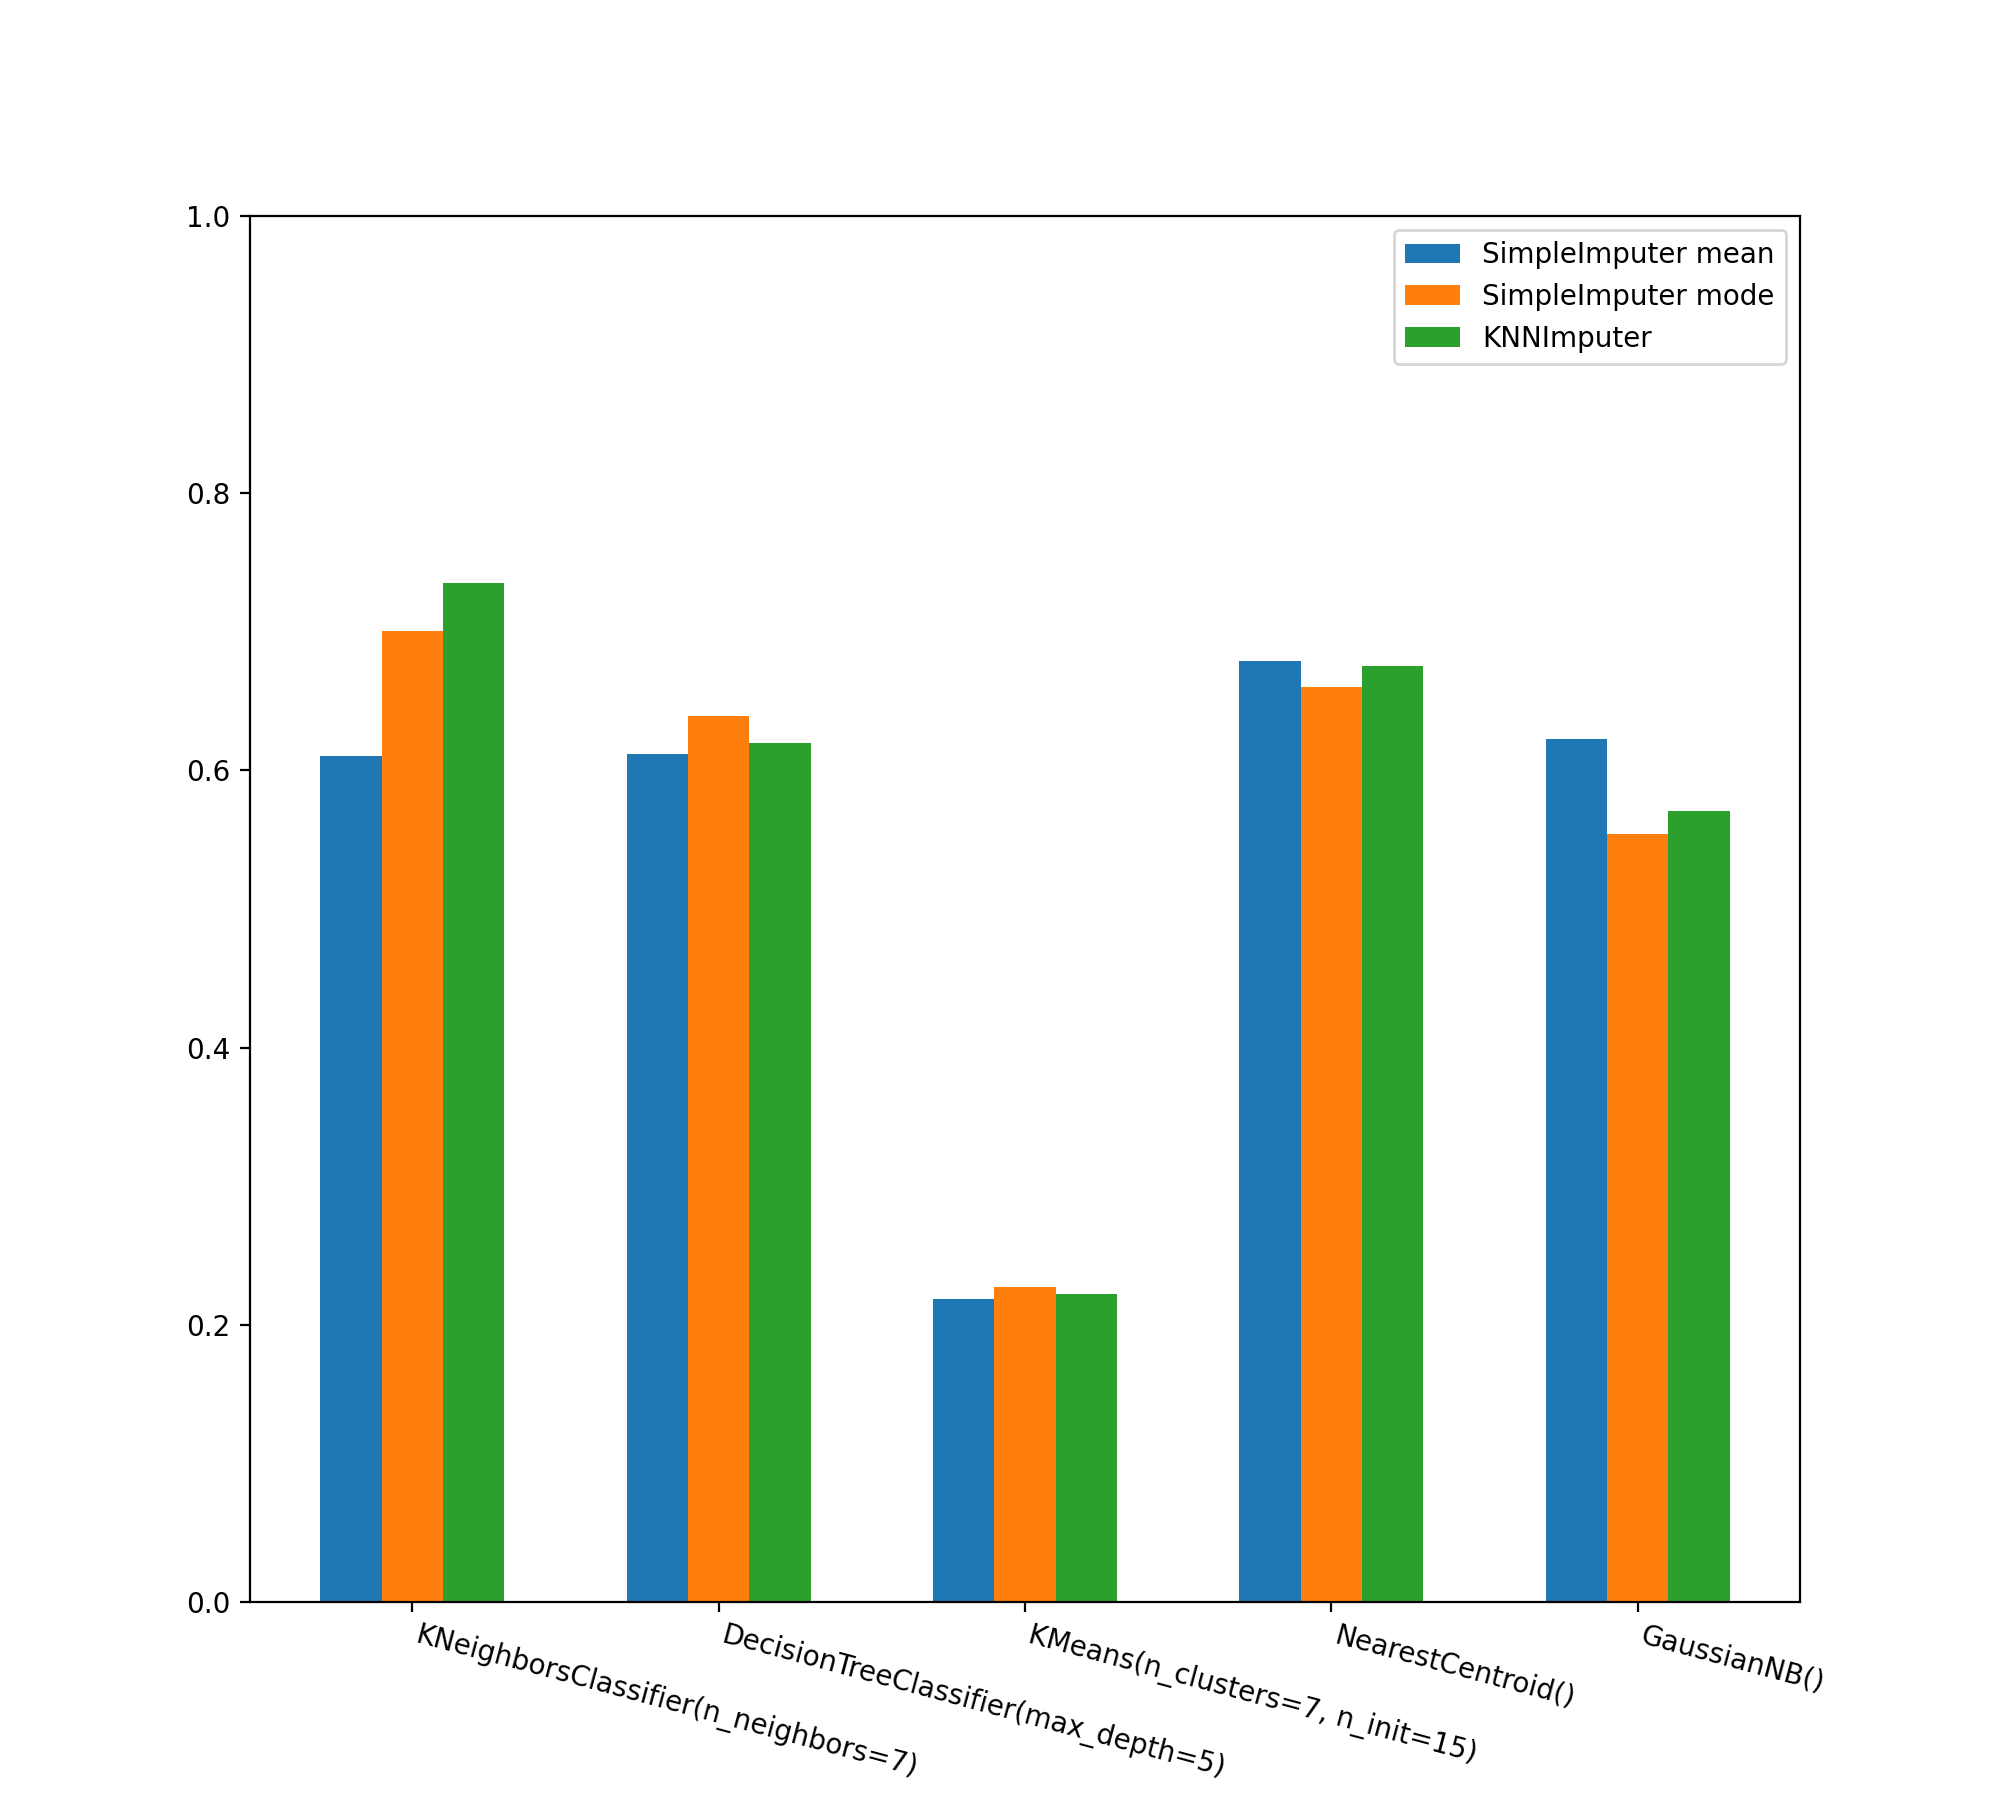

In [78]:
fig, ax = plt.subplots()
fig.set_size_inches(10,9)

result_simple_mean = results[results['param_imputer'] == 'SimpleImputer()']
result_simple_mode = results[results['param_imputer'] == "SimpleImputer(strategy='most_frequent')"]
result_knn = results[results['param_imputer'] == 'KNNImputer()']

bar_width = 0.2

x_axis = np.arange(len(result_simple_mean))

ax.bar(x_axis-bar_width, result_simple_mean['mean_test_score'], width=bar_width, label='SimpleImputer mean')
ax.bar(x_axis, result_simple_mode['mean_test_score'], width=bar_width, label='SimpleImputer mode')  
ax.bar(x_axis+bar_width, result_knn['mean_test_score'], width=bar_width, label='KNNImputer')

plt.xticks(x_axis, result_simple_mean['param_estimator'].astype(str), rotation=-15, ha='left')

plt.ylim((0,1))
plt.legend()
plt.show()